# Downloading Dataset from kaggle and storing it in Google drive

In [ ]:
# Import OS for navigation and environment set up
import os
# Check current location, '/content' is the Colab virtual machine
os.getcwd()
# Enable the Kaggle environment, use the path to the directory your Kaggle API JSON is stored in
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/Kaggle'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install kaggle

In [ ]:
# Navigate into Drive where you want to store your Kaggle data
os.chdir('/content/drive/MyDrive/Deep Learning/NLP/Image_captioning')
# Paste and run the copied API command, the data will download to the current directory
!kaggle datasets download -d shadabhussain/flickr8k
# Check contents of directory, you should see the .zip file for the competition in your Drive
os.listdir()

100% 2.12G/2.13G [00:25<00:00, 52.5MB/s]
100% 2.13G/2.13G [00:25<00:00, 90.3MB/s]


['Image_captioning.ipynb', 'flickr8k.zip']

In [ ]:
Archive=r'/content/drive/MyDrive/Deep Learning/NLP/Image_captioning/flickr8k.zip'
from zipfile import ZipFile
with ZipFile(Archive,'r') as z:
    z.extractall()
print('Archive Extraction done')

Archive Extraction done


# Step 1: Import the required libraries

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.compat.v1.keras.backend import set_session
import keras
import sys, time, os, warnings 
import numpy as np
import pandas as pd 
from collections import Counter 
warnings.filterwarnings("ignore")
print("python {}".format(sys.version))
print("keras version {}".format(keras.__version__)); del keras
print("tensorflow version {}".format(tf.__version__))
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
#set_session(tf.Session(config=config))

def set_seed(sd=123):
    from numpy.random import seed
    from tensorflow import set_random_seed
    import random as rn
    ## numpy random seed
    seed(sd)
    ## core python's random number 
    rn.seed(sd)
    ## tensor flow's random number
    set_random_seed(sd)

python 3.7.10 (default, Feb 20 2021, 21:17:23) 
[GCC 7.5.0]
keras version 2.4.3
tensorflow version 2.4.1


Flilckr8K contains 8,000 images that are each paired with five different captions which provide clear descriptions of the salient entities and events. The images were chosen from six different Flickr groups, and tend not to contain any well-known people or locations, but were manually selected to depict a variety of scenes and situations.

In [ ]:
## The location of the Flickr8K_ photos
dir_Flickr_jpg = "/content/drive/MyDrive/Deep Learning/NLP/Image_captioning/Flickr_Data/Flickr_Data/Images"
## The location of the caption file
dir_Flickr_text = "/content/drive/MyDrive/Deep Learning/NLP/Image_captioning/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt"

jpgs = os.listdir(dir_Flickr_jpg)
print("The number of jpg flies in Flicker8k: {}".format(len(jpgs)))

The number of jpg flies in Flicker8k: 8091


**Preliminary analysis**

**Import caption data**

Load the text data and save it into a panda dataframe df_txt.

- filename : jpg file name
- index : unique ID for each caption for the same image
- caption : string of caption, all in lower case

In [ ]:
## read in the Flickr caption data
file = open(dir_Flickr_text,'r')
text = file.read()
file.close()


datatxt = []
for line in text.split('\n'):
    col = line.split('\t')
    if len(col) == 1:
        continue
    w = col[0].split("#")
    datatxt.append(w + [col[1].lower()])

df_txt = pd.DataFrame(datatxt,columns=["filename","index","caption"])


uni_filenames = np.unique(df_txt.filename.values)
print("The number of unique file names : {}".format(len(uni_filenames)))
print("The distribution of the number of captions for each image:")
Counter(Counter(df_txt.filename.values).values())

The number of unique file names : 8092
The distribution of the number of captions for each image:


Counter({5: 8092})

Let's have a look at some of the pictures together with the captions.

The 5 captions for each image share many common words and very similar meaning.

Some sentences finish with "." but not all.



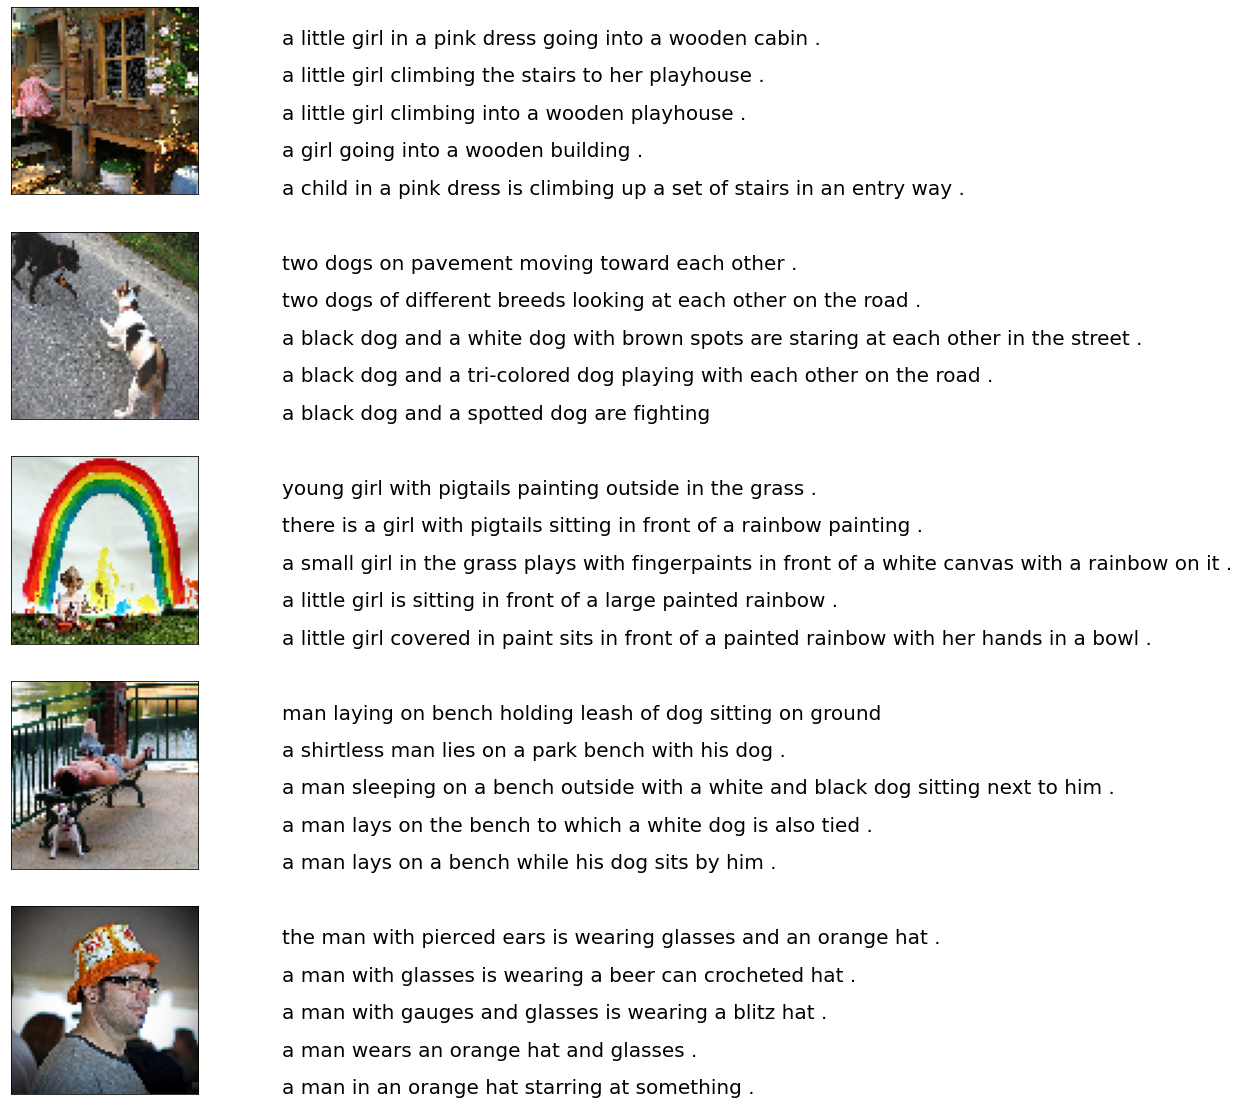

In [ ]:
from keras.preprocessing.image import load_img, img_to_array

npic = 5
npix = 80
target_size = (npix,npix,3)

count = 1
fig = plt.figure(figsize=(10,20))
for jpgfnm in uni_filenames[:npic]:
    filename = dir_Flickr_jpg + '/' + jpgfnm
    captions = list(df_txt["caption"].loc[df_txt["filename"]==jpgfnm].values)
    image_load = load_img(filename, target_size=target_size)
    
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1
    
    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions))
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=20)
    count += 1
plt.show()

**Data preparation**

We prepare text and image data separately.

**Text preparation**

We create a new dataframe dfword to visualize distribution of the words. It contains each word and its frequency in the entire tokens in decreasing order.

In [ ]:
def df_word(df_txt):
    vocabulary = []
    for txt in df_txt.caption.values:
        vocabulary.extend(txt.split())
    print('Vocabulary Size: %d' % len(set(vocabulary)))
    ct = Counter(vocabulary)
    dfword = pd.DataFrame({"word":ct.keys(),"count":ct.values()})
    dfword = dfword.sort_values("count",ascending=False)
    dfword = dfword.reset_index()[["word","count"]]
    return(dfword)
dfword = df_word(df_txt)
dfword.head(3)

Vocabulary Size: 8918


,word,count
0,a,62989
1,.,36581
2,in,18975


**The most and least frequently appearing words**

The most common words are articles such as "a", or "the", or punctuations.

These words do not have much infomation about the data.

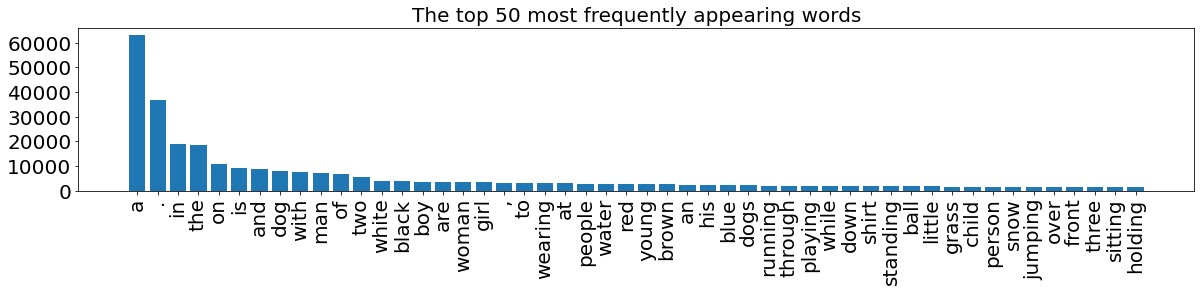

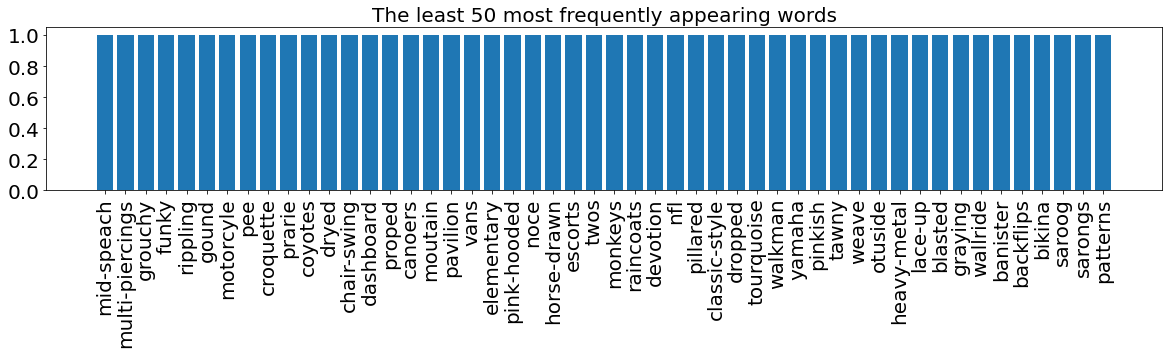

In [ ]:
topn = 50

def plthist(dfsub, title="The top 50 most frequently appearing words"):
    plt.figure(figsize=(20,3))
    plt.bar(dfsub.index,dfsub["count"])
    plt.yticks(fontsize=20)
    plt.xticks(dfsub.index,dfsub["word"],rotation=90,fontsize=20)
    plt.title(title,fontsize=20)
    plt.show()

plthist(dfword.iloc[:topn,:],
        title="The top 50 most frequently appearing words")
plthist(dfword.iloc[-topn:,:],
        title="The least 50 most frequently appearing words")

In order to clean the caption, I will create three functions that:

- remove punctuation
- remove single character
- remove numeric characters

To see how these functions work, I will process a single example string using these three functions.

In [ ]:
import string
text_original = "I ate 1000 apples and a banana. I have python v2.7. It's 2:30 pm. Could you buy me iphone7?"

print(text_original)
print("\nRemove punctuations..")
def remove_punctuation(text_original):
    text_no_punctuation = text_original.translate(string.punctuation)
    return(text_no_punctuation)
text_no_punctuation = remove_punctuation(text_original)
print(text_no_punctuation)


print("\nRemove a single character word..")
def remove_single_character(text):
    text_len_more_than1 = ""
    for word in text.split():
        if len(word) > 1:
            text_len_more_than1 += " " + word
    return(text_len_more_than1)
text_len_more_than1 = remove_single_character(text_no_punctuation)
print(text_len_more_than1)

print("\nRemove words with numeric values..")
def remove_numeric(text,printTF=False):
    text_no_numeric = ""
    for word in text.split():
        isalpha = word.isalpha()
        if printTF:
            print("    {:10} : {:}".format(word,isalpha))
        if isalpha:
            text_no_numeric += " " + word
    return(text_no_numeric)
text_no_numeric = remove_numeric(text_len_more_than1,printTF=True)
print(text_no_numeric)

I ate 1000 apples and a banana. I have python v2.7. It's 2:30 pm. Could you buy me iphone7?

Remove punctuations..
I ate 1000 apples and a banana. I have python v2.7. It's 2:30 pm. Could you buy me iphone7?

Remove a single character word..
 ate 1000 apples and banana. have python v2.7. It's 2:30 pm. Could you buy me iphone7?

Remove words with numeric values..
    ate        : True
    1000       : False
    apples     : True
    and        : True
    banana.    : False
    have       : True
    python     : True
    v2.7.      : False
    It's       : False
    2:30       : False
    pm.        : False
    Could      : True
    you        : True
    buy        : True
    me         : True
    iphone7?   : False
 ate apples and have python Could you buy me


Clean all captions

Using the three functions, I will clean all captions.

In [ ]:
def text_clean(text_original):
    text = remove_punctuation(text_original)
    text = remove_single_character(text)
    text = remove_numeric(text)
    return(text)


for i, caption in enumerate(df_txt.caption.values):
    newcaption = text_clean(caption)
    df_txt["caption"].iloc[i] = newcaption

After cleaning, the vocabularly size get reduced by about 200.

Vocabulary Size: 8357


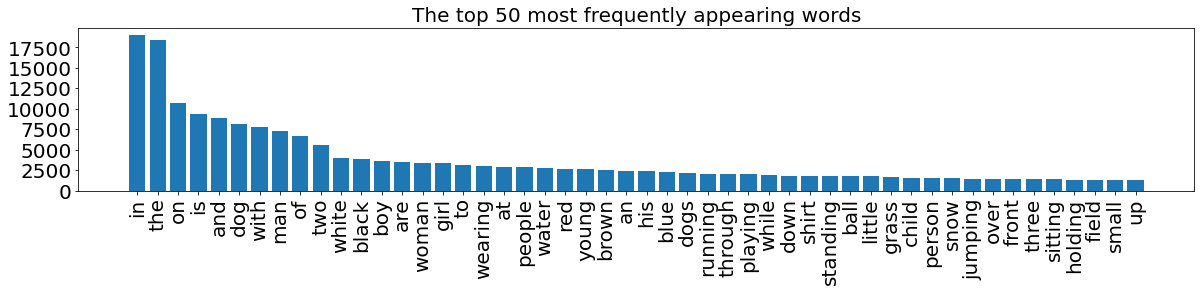

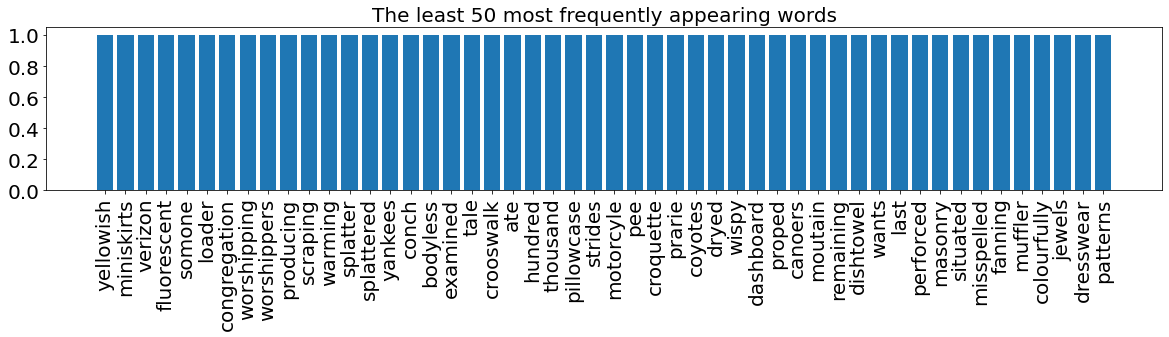

In [ ]:
dfword = df_word(df_txt)
plthist(dfword.iloc[:topn,:],
        title="The top 50 most frequently appearing words")
plthist(dfword.iloc[-topn:,:],
        title="The least 50 most frequently appearing words")

**Add start and end sequence tokens**

In [ ]:
from copy import copy
def add_start_end_seq_token(captions):
    caps = []
    for txt in captions:
        txt = 'startseq ' + txt + ' endseq'
        caps.append(txt)
    return(caps)
df_txt0 = copy(df_txt)
df_txt0["caption"] = add_start_end_seq_token(df_txt["caption"])
df_txt0.head(5)
del df_txt

**Image preparation**

Create features for each image using VGG16's pre-trained networks

Read in the pre-trained network. Notice that this network takes input of size (224,224,3). The output layer contains 1,000 nodes.



In [ ]:
from keras.applications import VGG16
IMAGE_SIZE = [64, 64]
modelvgg = VGG16(input_shape = IMAGE_SIZE + [3],include_top=False,weights='imagenet')
## load the locally saved weights 
#modelvgg.load_weights("../output/vgg16_weights_tf_dim_ordering_tf_kernels.h5")
modelvgg.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
______________________________________________________________

VGG16 is developed to classify images into 1,000 different classes. As I am not using VGG16 for the sake of the classification but I just need it for extracting features, I will remove the last layer from the network.

# Images

In [ ]:
import progressbar

In [ ]:
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
from collections import OrderedDict

images = OrderedDict()
npix = 64
target_size = (npix,npix,3)
with progressbar.ProgressBar(max_value=len(jpgs)) as bar:
    for i,name in enumerate(jpgs):
        # load an image from file
        filename = dir_Flickr_jpg + '/' + name
        image = load_img(filename, target_size=target_size)
        # convert the image pixels to a numpy array
        image = img_to_array(image)
        nimage = preprocess_input(image)
        y_pred = modelvgg.predict(nimage.reshape( (1,) + nimage.shape[:3]))
        images[name] = y_pred.flatten()
        bar.update(i)

100% (8091 of 8091) |####################| Elapsed Time: 0:44:29 Time:  0:44:29


https://www.kaggle.com/anunay999/image-captioning-using-vgg16

https://fairyonice.github.io/Develop_an_image_captioning_deep_learning_model_using_Flickr_8K_data.html

**Visualization of the VGG16 features**

For each image, 4096 features are created. As I cannot visualize the 4096 dimensional space, I will create 2 dimentional representation of the space using PCA and visualize the distribution of the sample images.

In [ ]:
from sklearn.decomposition import PCA

encoder = y_pred.flatten()
pca = PCA(n_components=2)
y_pca = pca.fit_transform(encoder)

ValueError: ignored

In [ ]:
len(images.values())

8091

In [ ]:
encoder = np.array(images.values())
encoder

**Do photo features make sense?**

I manually selected similar images that are creating clusters. Namely I created red, green, magenta, blue, yellow and purple clusters. From each cluster, I plotted the original images. As you see, images from the same clusters tend to be very similar:

- red: many people are in one image
- green: dogs on green, yard or on bed
- magenta: dogs in snow or with water splash
- blue: guys doing sports with helmets
- yellow: not sure what these are?? I see many pictures are densely clustered around this area and


Photo features seem to make sense!

NameError: ignored

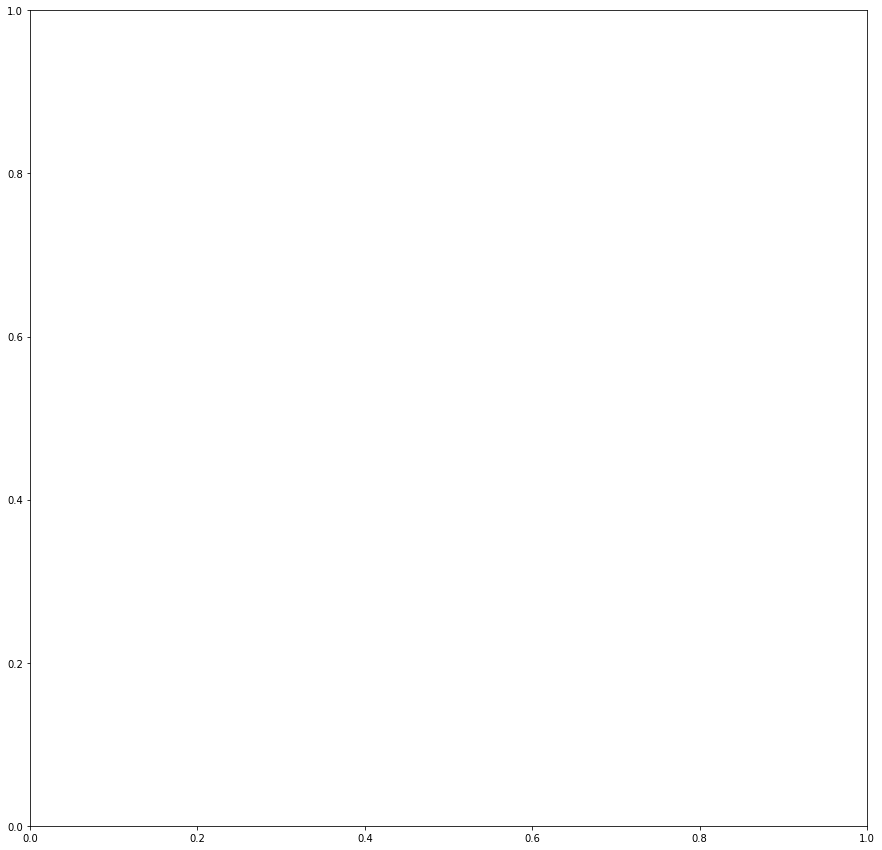

In [ ]:
## some selected pictures that are creating clusters
picked_pic = OrderedDict()
picked_pic["red"]     = [1502,5298,2070,7545,1965]
picked_pic["green"]   = [746,7627,6640,2733, 4997]
picked_pic["magenta"] = [5314,5879,310,5303, 3784]
picked_pic["blue"]    = [4644,4209,7326,7290,4394]
picked_pic["yellow"]  = [5895,9,27,62,123]
picked_pic["purple"]  = [5087]

fig, ax = plt.subplots(figsize=(15,15))
ax.scatter(y_pca[:,0],y_pca[:,1],c="white")

for irow in range(y_pca.shape[0]):
    ax.annotate(irow,y_pca[irow,:],color="black",alpha=0.5)
for color, irows in picked_pic.items():
    for irow in irows:
        ax.annotate(irow,y_pca[irow,:],color=color)
ax.set_xlabel("pca embedding 1",fontsize=30)
ax.set_ylabel("pca embedding 2",fontsize=30)
plt.show()


## plot of images 
fig = plt.figure(figsize=(16,20))
count = 1
for color, irows in picked_pic.items():
    for ivec in irows:
        name = jpgs[ivec]
        filename = dir_Flickr_jpg + '/' + name
        image = load_img(filename, target_size=target_size)
    
        ax = fig.add_subplot(len(picked_pic),5,count,
                         xticks=[],yticks=[])
        count += 1
        plt.imshow(image)
        plt.title("{} ({})".format(ivec,color))
plt.show()

**Link the text and image data**

In this dataset, a single image has 5 captions. I will only use one caption out of 5 for simplicity.

Each row of the dtexts and dimages contain the same info. Remove captions (or images) that do not have corresponding images (or captions).

In [ ]:
dimages, keepindex = [],[]
df_txt0 = df_txt0.loc[df_txt0["index"].values == "0",: ]
for i, fnm in enumerate(df_txt0.filename):
    if fnm in images.keys():
        dimages.append(images[fnm])
        keepindex.append(i)
        
fnames = df_txt0["filename"].iloc[keepindex].values
dcaptions = df_txt0["caption"].iloc[keepindex].values
dimages = np.array(dimages)

**Tokenizer**

Change character vector to integer vector using Tokenizer

In [ ]:
from keras.preprocessing.text import Tokenizer
## the maximum number of words in dictionary
nb_words = 8000
tokenizer = Tokenizer(nb_words=nb_words)
tokenizer.fit_on_texts(dcaptions)
vocab_size = len(tokenizer.word_index) + 1
print("vocabulary size : {}".format(vocab_size))
dtexts = tokenizer.texts_to_sequences(dcaptions)
print(dtexts[:5])

vocabulary size : 4359
[[1, 38, 3, 66, 144, 7, 124, 52, 405, 9, 365, 3, 24, 2323, 521, 2], [1, 12, 8, 5, 751, 8, 17, 366, 2], [1, 48, 15, 170, 3, 583, 101, 3, 41, 9, 550, 1191, 11, 55, 213, 3, 1071, 2], [1, 10, 620, 6, 150, 27, 23, 8, 101, 46, 112, 2], [1, 10, 3, 24, 82, 96, 1192, 19, 162, 2]]


Split between training and testing data

In [ ]:

prop_test, prop_val = 0.2, 0.2 

N = len(dtexts)
Ntest, Nval = int(N*prop_test), int(N*prop_val)

def split_test_val_train(dtexts,Ntest,Nval):
    return(dtexts[:Ntest], 
           dtexts[Ntest:Ntest+Nval],  
           dtexts[Ntest+Nval:])

dt_test,  dt_val, dt_train   = split_test_val_train(dtexts,Ntest,Nval)
di_test,  di_val, di_train   = split_test_val_train(dimages,Ntest,Nval)
fnm_test,fnm_val, fnm_train  = split_test_val_train(fnames,Ntest,Nval)

The maximume length of captions

In [ ]:
maxlen = np.max([len(text) for text in dtexts])


The final preprocessing so that the data can be used as input and output of the Keras model.

In [ ]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

def preprocessing(dtexts,dimages):
    N = len(dtexts)
    print("# captions/images = {}".format(N))

    assert(N==len(dimages))
    Xtext, Ximage, ytext = [],[],[]
    for text,image in zip(dtexts,dimages):

        for i in range(1,len(text)):
            in_text, out_text = text[:i], text[i]
            in_text = pad_sequences([in_text],maxlen=maxlen).flatten()
            out_text = to_categorical(out_text,num_classes = vocab_size)

            Xtext.append(in_text)
            Ximage.append(image)
            ytext.append(out_text)

    Xtext  = np.array(Xtext)
    Ximage = np.array(Ximage)
    ytext  = np.array(ytext)
    print(" {} {} {}".format(Xtext.shape,Ximage.shape,ytext.shape))
    return(Xtext,Ximage,ytext)


Xtext_train, Ximage_train, ytext_train = preprocessing(dt_train,di_train)
Xtext_val,   Ximage_val,   ytext_val   = preprocessing(dt_val,di_val)
# pre-processing is not necessary for testing data
#Xtext_test,  Ximage_test,  ytext_test  = preprocessing(dt_test,di_test)

# captions/images = 4855
 (49502, 30) (49502, 2048) (49502, 4359)
# captions/images = 1618
 (16314, 30) (16314, 2048) (16314, 4359)


**Model**

This model takes two inputs:

- 4096-dimensional image features from pre-trained VGG model
- tokenized captions up to tth word.

The single output is:

- tokenized t+1th word of caption

**Prediction**

Given the caption prediction up to the tth word, the model can predict the t+1st word in the caption, and then the input caption can be augmented with the predicted word to contain the caption up to the t+1th word. The augmented caption up to the t+1st word can, in turn, be used as input to predict the t+2nd word in caption. The process is repeated until the "endseq" is predicted.

**A bit more detail:**

[Image] 4096-dimensional image features from pre-trained VGG model
The image feature is passed to fully connected layer with 256 hidden units.
[Caption up to t] tokenized captions up to tth word.

The tokenized caption up to tth time point is passed to embedding layer where each word is represented with a "dim_embedding" dimensional vector. This means that a single caption is represented as many time series of length "max_len".
The time series are passed to LSTM with 256 hidden states, and then a single output at the final time point is passed to the higher layer.
The networks are merged by simply adding the two vectors of size 256.

The vector of length 256 is passed to two dense layers and the final dense layer return probability that the t+1st word is kth word in the vocabulary (k=1,...,4476).

In [ ]:
from keras import models

In [ ]:
from keras import layers
print(vocab_size)
## image feature

dim_embedding = 64

input_image = layers.Input(shape=(Ximage_train.shape[1],))
fimage = layers.Dense(256,activation='relu',name="ImageFeature")(input_image)
## sequence model
input_txt = layers.Input(shape=(maxlen,))
ftxt = layers.Embedding(vocab_size,dim_embedding, mask_zero=True)(input_txt)
ftxt = layers.LSTM(256,name="CaptionFeature")(ftxt)
## combined model for decoder
decoder = layers.add([ftxt,fimage])
decoder = layers.Dense(256,activation='relu')(decoder)
output = layers.Dense(vocab_size,activation='softmax')(decoder)
model = models.Model(inputs=[input_image, input_txt],outputs=output)

model.compile(loss='categorical_crossentropy', optimizer='adam')

print(model.summary())

4359
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 30, 64)       278976      input_3[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
CaptionFeature (LSTM)           (None, 256)          328704      embedding[0][0]                  
_________________________________________________________________________________________

Model training

In [ ]:
# fit model
start = time.time()
hist = model.fit([Ximage_train, Xtext_train], ytext_train, 
                  epochs=5, verbose=2, 
                  batch_size=64,
                  validation_data=([Ximage_val, Xtext_val], ytext_val))
end = time.time()
print("TIME TOOK {:3.2f}MIN".format((end - start )/60))

Epoch 1/5
774/774 - 59s - loss: 5.7975 - val_loss: 5.3448
Epoch 2/5
774/774 - 54s - loss: 5.0044 - val_loss: 4.9677
Epoch 3/5
774/774 - 54s - loss: 4.5439 - val_loss: 4.7417
Epoch 4/5
774/774 - 54s - loss: 4.2559 - val_loss: 4.7152
Epoch 5/5
774/774 - 54s - loss: 4.0543 - val_loss: 4.7037
TIME TOOK 4.57MIN


In [ ]:
print(Ximage_train.shape,Xtext_train.shape,ytext_train.shape)

(49502, 2048) (49502, 30) (49502, 4359)


**Validation loss and training loss over epochs**

The model over fit very quickly. This makes sense considering the small size of our data.

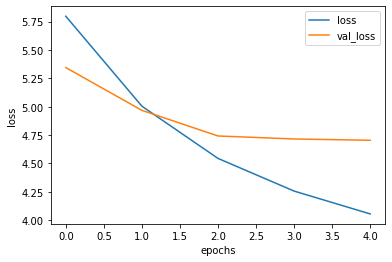

In [ ]:
for label in ["loss","val_loss"]:
    plt.plot(hist.history[label],label=label)
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

**Prediction**

Prediction of testing image makes sense!

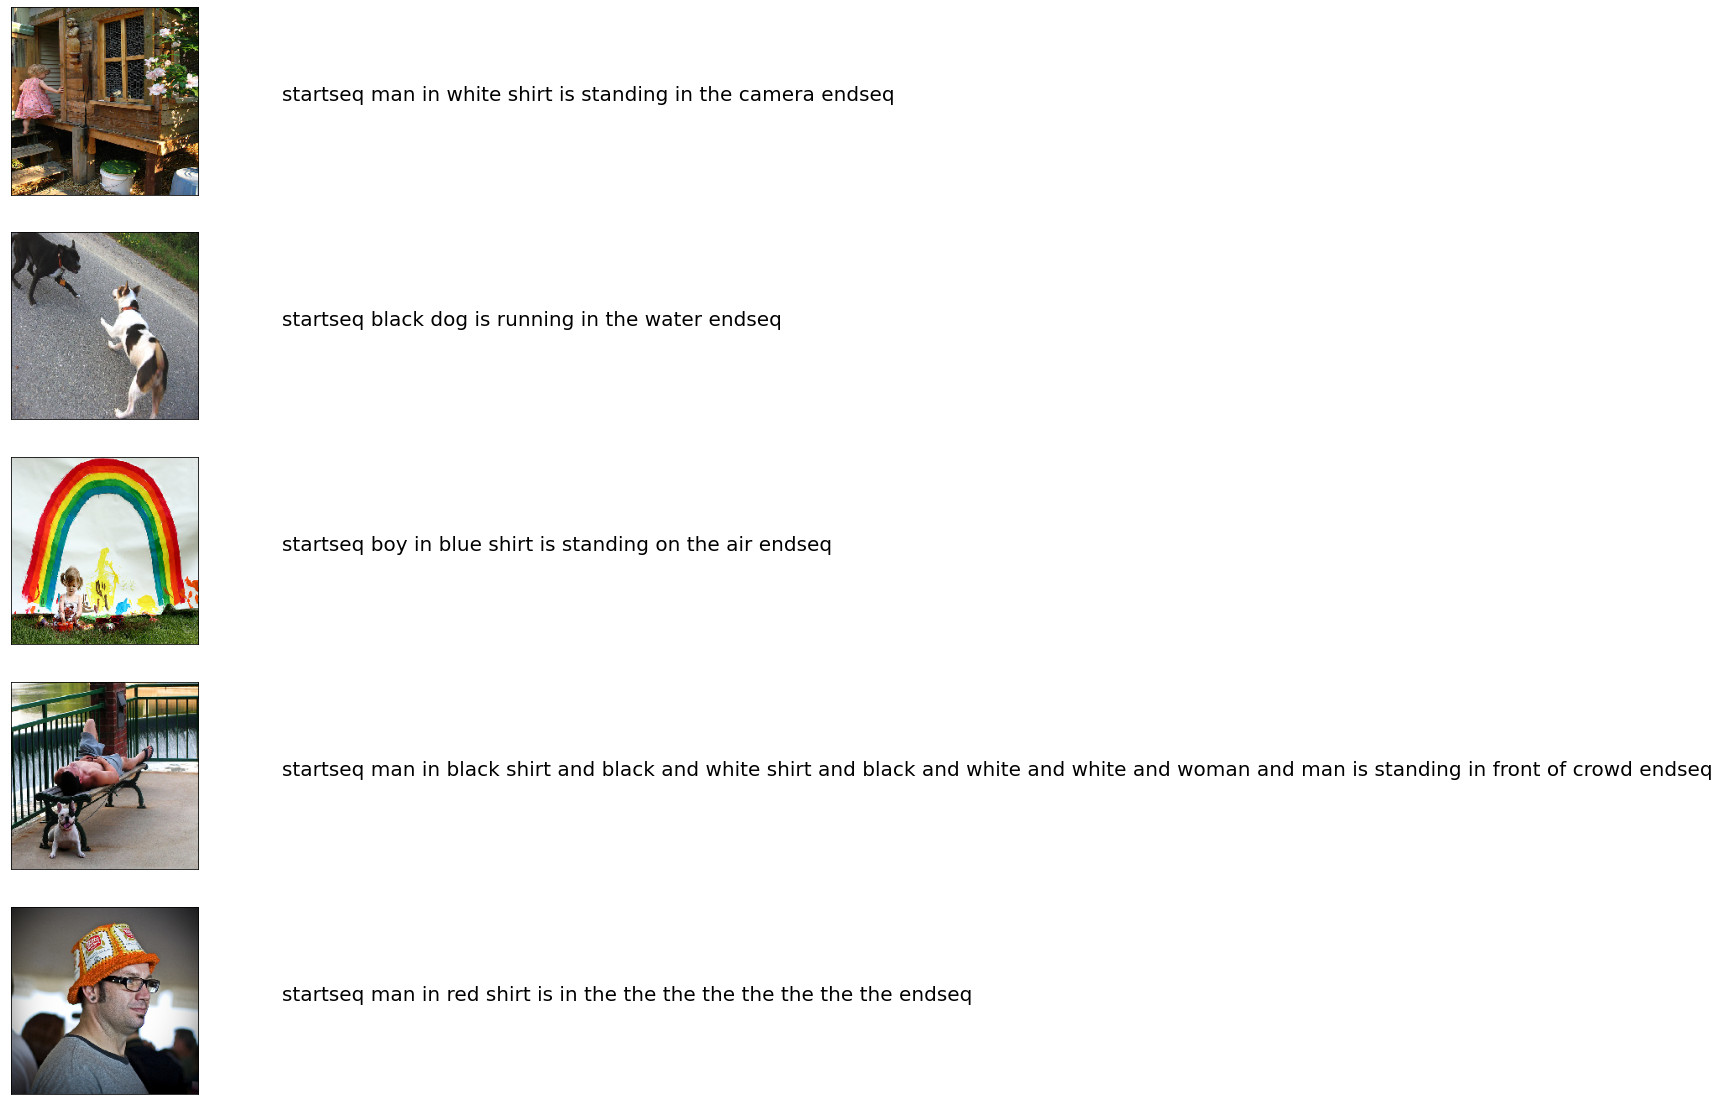

In [ ]:

index_word = dict([(index,word) for word, index in tokenizer.word_index.items()])
def predict_caption(image):
    '''
    image.shape = (1,4462)
    '''

    in_text = 'startseq'

    for iword in range(maxlen):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence],maxlen)
        yhat = model.predict([image,sequence],verbose=0)
        yhat = np.argmax(yhat)
        newword = index_word[yhat]
        in_text += " " + newword
        if newword == "endseq":
            break
    return(in_text)



npic = 5
npix = 224
target_size = (npix,npix,3)

count = 1
fig = plt.figure(figsize=(10,20))
for jpgfnm, image_feature in zip(fnm_test[:npic],di_test[:npic]):
    ## images 
    filename = dir_Flickr_jpg + '/' + jpgfnm
    image_load = load_img(filename, target_size=target_size)
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1

    ## captions
    caption = predict_caption(image_feature.reshape(1,len(image_feature)))
    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.text(0,0.5,caption,fontsize=20)
    count += 1

plt.show()


**Bilingual evaluation understudy (BLEU)**

I want to evaluate the model performance in the prediction. Is there any good metric?

BLEU is a well-acknowledged metric to measure the similarly of one hypothesis sentence to multiple reference sentences. Given a single hypothesis sentence and multiple reference sentences, it returns value between 0 and 1. The metric close to 1 means that the two are very similar. The metric was introduced in 2002 BLEU: a Method for Automatic Evaluation of Machine Translation. Although there are many problems in this metric, for example grammatical correctness are not taken into account, BLEU is very well accepted partly because it is easy to calculate.

**Basic idea of BLEU**

The authors of the paper say that:

The primary programming task for a BLEU implementor is to compare n-grams of the candidate with the n-grams of the reference translation and count the number of matches. These matches are position-independent. The more the matches, the better the candidate translation is.

For example let's consider the scenario where I want to compare the similarly between the hypothesis sentence and the reference sentence. The hypothesis sentence is

I like dogs

and the reference sentence is:

I do like dogs

From the hypothesis sentence, I can create 2 2-grams:

- (I, like)
- (like, dogs)
From the reference sentence, I can create 3 2-grams:

- (I, do)
- (do, like)
- (like, dogs)

Which 2-gram from hypothesis exists in reference? The reference sentence has (like, dog) that is one of the 2-gram from hypothesis. This means that out of the two 2-grams from hypothesis, 1 exists in the reference i.e., 50% of 2-gram from the hypothesis exists in reference. This 50% is what's called "modified precision".

This modified precision has the problem that when the number of words is larger than the hypothesis length, then the modified precision tends to be larger. For example, if the reference sentence contains 10000 words and its sub-sentence happened to contain "I do like dogs" sentence, this also gives the modified precision of 50%. However, the reference sentence and the hypothesis sentence should be considered less similar. To account for this, BLEU calculation penalizes the long reference sentence. The penalty is simply

exp(1−lengh of referencelength of hypothesis)
Modified precision is multiplied by this reference factor to yield 2-gram BLEU. In this particular example, the penalty is exp(1−4/3)=0.717 so the 2-gram BLEU is 0.717*0.5 = 0.3585.

Finally, 1-gram BLEU, 2-gram BLEU, 3-gram BLEU and 4-gram BLEU are calculated and its average is reported as BLEU.

**Implementation**

BLEU score calculation is implemented in nltk.util and the source code is available. I found this source code is the easiest way to understand this metric. So I will go over the script to understand how the calculation works.

Let's introduce one hypothesis string and one reference string, and see how similar they are according to BLEU.

In [ ]:
hypothesis = "I like dog"
hypothesis = hypothesis.split()
reference  = "I do like dog"
references = [reference.split()] ## references must be a list containing list. 

According to BLEU the two sentences are reasonably similar.

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
print("BLEU={:4.3f}".format(sentence_bleu(references,hypothesis)))

BLEU=0.603


If I change the hypothesis sentence a bit, this worsen the BLEU.

In [ ]:
hypothesis2 = "I love dog!".split()
print("BLEU={:4.3f}".format(sentence_bleu(references,  hypothesis2)))

BLEU=0.544


**Back to image captioning problem**

Now we understand what BLEU does and we are ready to calculate the BLEU for our test set.

In [ ]:
index_word = dict([(index,word) for word, index in tokenizer.word_index.items()])


nkeep = 5
pred_good, pred_bad, bleus = [], [], [] 
count = 0 
for jpgfnm, image_feature, tokenized_text in zip(fnm_test,di_test,dt_test):
    count += 1
    if count % 200 == 0:
        print("  {:4.2f}% is done..".format(100*count/float(len(fnm_test))))
    
    caption_true = [ index_word[i] for i in tokenized_text ]     
    caption_true = caption_true[1:-1] ## remove startreg, and endreg
    ## captions
    caption = predict_caption(image_feature.reshape(1,len(image_feature)))
    caption = caption.split()
    caption = caption[1:-1]## remove startreg, and endreg
    
    bleu = sentence_bleu([caption_true],caption)
    bleus.append(bleu)
    if bleu > 0.7 and len(pred_good) < nkeep:
        pred_good.append((bleu,jpgfnm,caption_true,caption))
    elif bleu < 0.3 and len(pred_bad) < nkeep:
        pred_bad.append((bleu,jpgfnm,caption_true,caption))

  12.36% is done..
  24.72% is done..
  37.08% is done..
  49.44% is done..
  61.80% is done..
  74.17% is done..
  86.53% is done..
  98.89% is done..


The mean BLEU value for testing data

In [ ]:
print("Mean BLEU {:4.3f}".format(np.mean(bleus)))

Mean BLEU 0.376


Plot the images with good captions (BLEU > 0.9) and bad captions (BLEU < 0.1)

Bad Caption


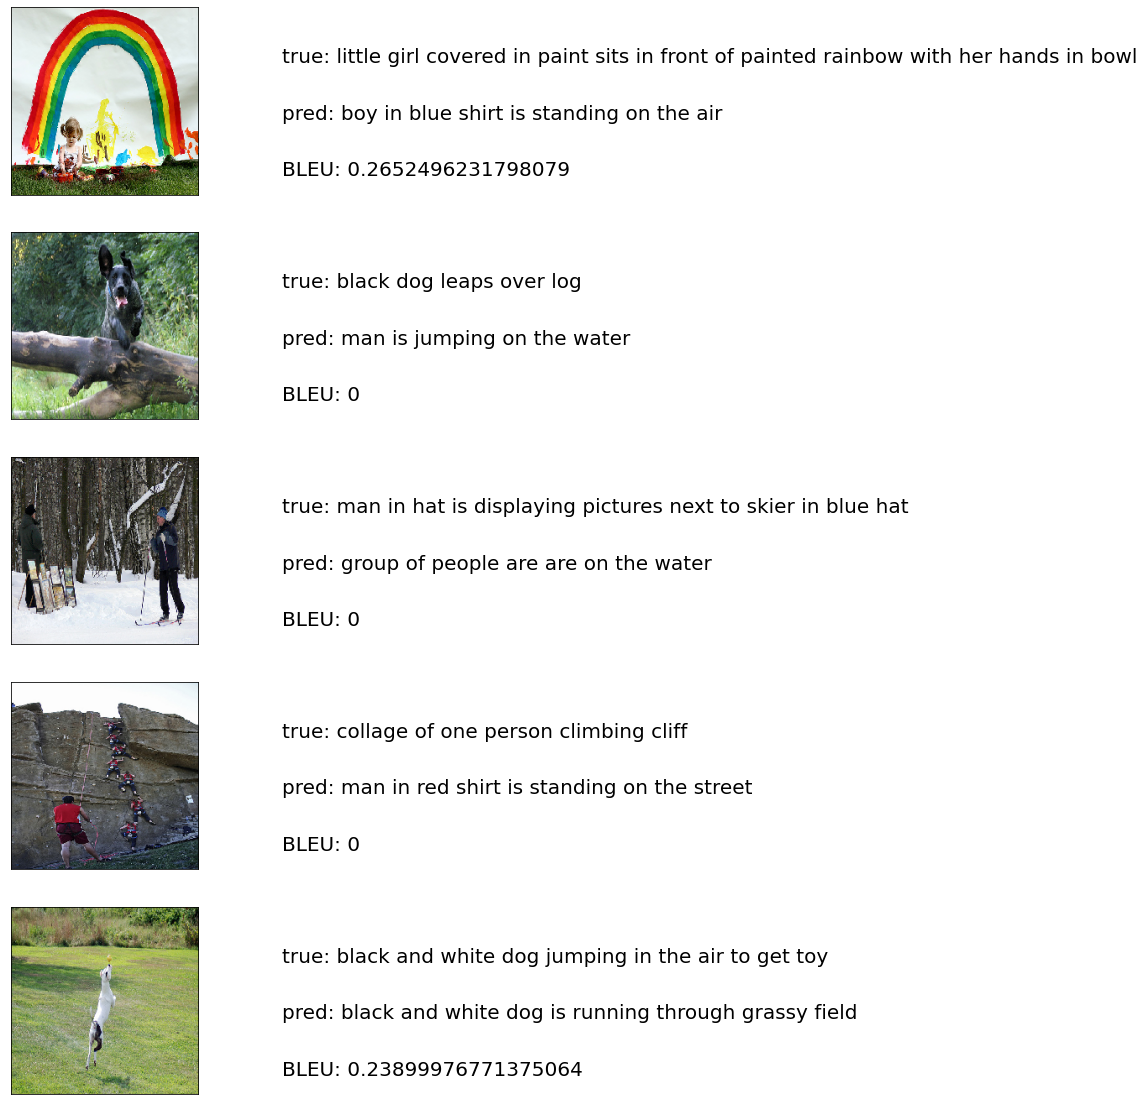

Good Caption


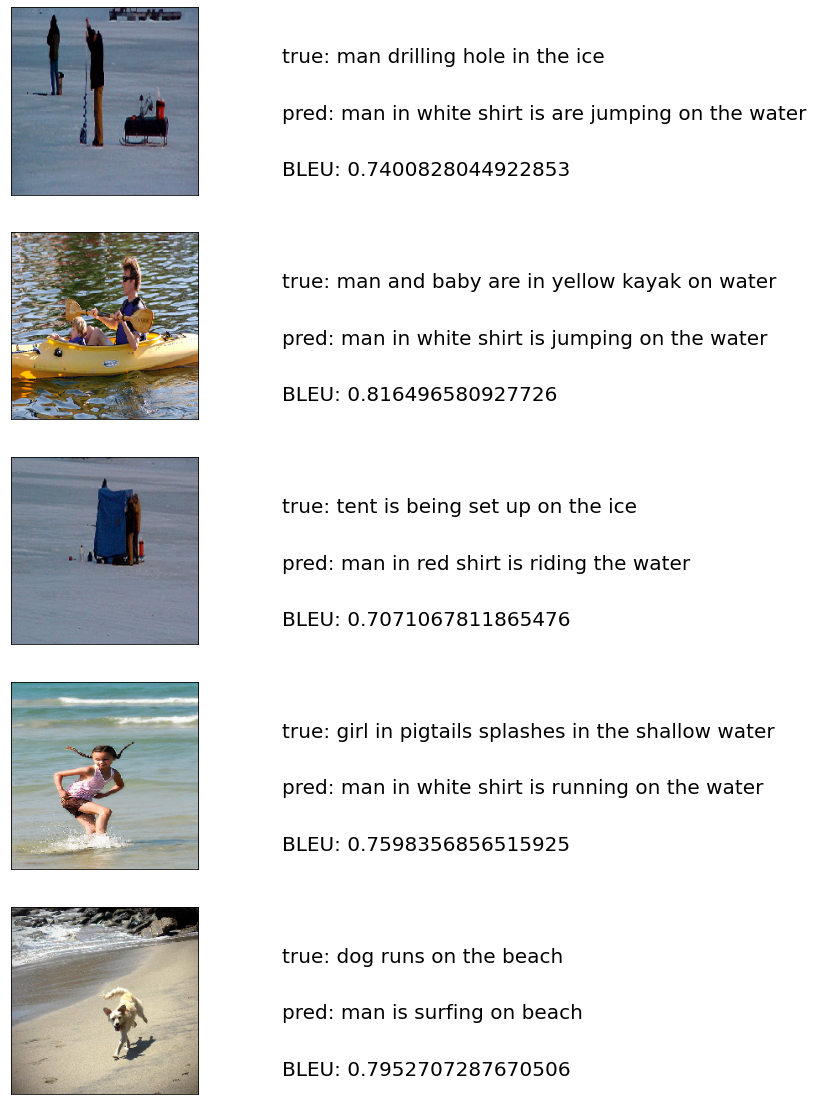

In [ ]:
def plot_images(pred_bad):
    def create_str(caption_true):
        strue = ""
        for s in caption_true:
            strue += " " + s
        return(strue)
    npix = 224
    target_size = (npix,npix,3)    
    count = 1
    fig = plt.figure(figsize=(10,20))
    npic = len(pred_bad)
    for pb in pred_bad:
        bleu,jpgfnm,caption_true,caption = pb
        ## images 
        filename = dir_Flickr_jpg + '/' + jpgfnm
        image_load = load_img(filename, target_size=target_size)
        ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        count += 1

        caption_true = create_str(caption_true)
        caption = create_str(caption)
        
        ax = fig.add_subplot(npic,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)
        ax.text(0,0.7,"true:" + caption_true,fontsize=20)
        ax.text(0,0.4,"pred:" + caption,fontsize=20)
        ax.text(0,0.1,"BLEU: {}".format(bleu),fontsize=20)
        count += 1
    plt.show()

print("Bad Caption")
plot_images(pred_bad)
print("Good Caption")
plot_images(pred_good)